In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/iris/config.py:139: UserWarning: Ignoring config item 'Resources':'test_data_dir' (section:option) as '/home/h05/itwl/projects/git/iris-test-data/test_data' is not a valid directory path.
  warnings.warn(msg.format(section, option, c_path))


In [3]:
train_files = ["ssp126", "ssp585", "historical", "1pctCO2", "hist-GHG"]

In [4]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data(file) for file in train_files])
y_train_pr = np.vstack([create_predictdand_data(file)['pr'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test = create_predictor_data('ssp245')
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = 86400 * Y_test["pr"].mean('member')

In [5]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
assert len(X_train) == len(y_train_pr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr_truth = pr_truth[~nan_test_mask]

In [6]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
train_CO2_5Y_mean, train_CO2_5Y_std = X_train['CO2_5YR'].mean(), X_train['CO2_5YR'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
X_train.CO2_5YR = (X_train.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std
X_test.CO2_5YR = (X_test.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

In [7]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

In [8]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])

kernel_CO2_5Y = gpflow.kernels.RBF(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

In [9]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_pr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [10]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 11468591.118862808
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.97284462e+01,  2.40725800e-01,  1.54110552e+01, -3.92686068e+01,
        2.53240840e+01, -3.66098898e-01, -1.34017186e+00, -7.04109750e-01,
       -2.33500566e+01,  1.02531349e+02,  2.53240840e+01, -3.66098898e-01,
       -1.34017186e+00, -7.04109750e-01, -2.33500566e+01,  1.02531349e+02,
       -2.73443247e+01,  3.74564103e+01,  4.80094603e+02,  4.20082308e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 292
      nit: 251
   status: 0
  success: True
        x: array([ 5.12801321, -0.33046414,  2.41145714, -2.93558906,  5.35182036,
       17.49882332,  0.58091029, 23.82126891, -6.83677407, -0.80941587,
        5.35182036, 17.49882332,  0.58091029, 23.82126891, -6.83677407,
       -0.80941587, -0.03511634, -3.65388221, -0.10363137,  0.061444  ])

In [11]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [12]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [82, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [82, 96, 144])
posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

In [13]:
print(f"RMSE at 2050: {get_rmse(pr_truth[31], posterior_pr_data[31])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[81], posterior_pr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[26:37], posterior_pr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[71:], posterior_pr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[31:], posterior_pr_data[31:]).mean()}")

RMSE at 2050: 0.4498785469719031
RMSE at 2100: 0.5391156568985108
RMSE 2045-2055: 0.5145961335086813
RMSE 2090-2100: 0.5113702877371721
RMSE 2050-2100: 0.5276030740798856


[Text(0.5, 1.0, 'Difference')]

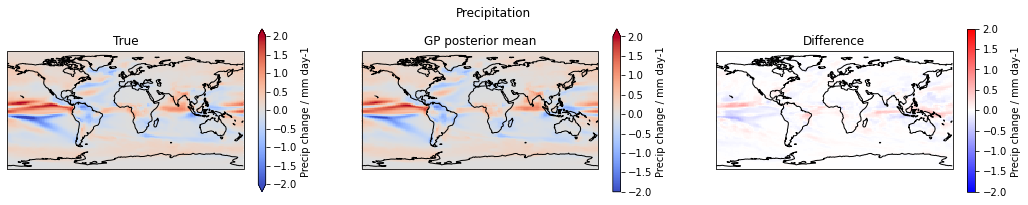

In [16]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precipitation')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

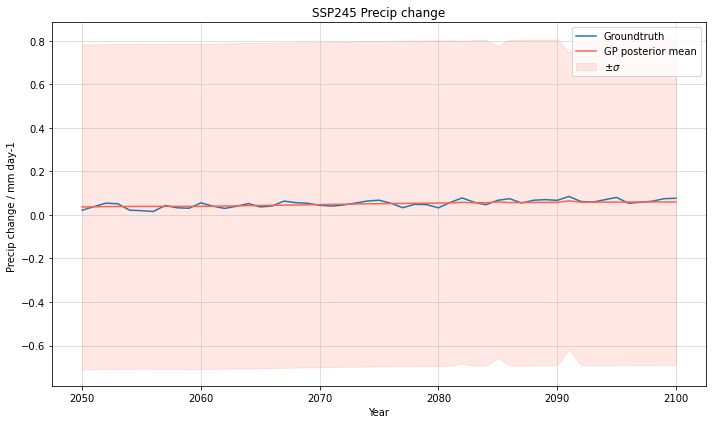

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

time = list(range(2050, 2101))
weights = np.cos(np.deg2rad(pr_truth.lat))


gt = pr_truth.sel(time=slice(2050,None)).weighted(weights).mean(['lat', 'lon']).data
mu_post = posterior_pr_data.sel(time=slice(2050,None)).weighted(weights).mean(['lat', 'lon']).data
sigma_post = posterior_pr_std_data.sel(time=slice(2050,None)).weighted(weights).mean(['lat', 'lon']).data

ax.plot(time, gt, 
        label='Groundtruth')
ax.plot(time, mu_post, 
        label='GP posterior mean', color='tomato')
ax.fill_between(time, mu_post - sigma_post, mu_post + sigma_post,
                label=r'$\pm\sigma$', color='tomato', alpha=0.15)
ax.set_title("SSP245 Precip change")
ax.set_xlabel("Year")
ax.set_ylabel("Precip change / mm day-1 ")
ax.grid(alpha=0.5)
plt.legend()
plt.tight_layout()